# 1. Подготовка

In [135]:
# все импорты
import pandas as pd
import numpy as np
import lightgbm as lgb
import scipy.stats as scs
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose

<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, что все импорты собраны в первой ячейке ноутбука! Если у того, кто будет запускать твой ноутбук будут отсутствовать некоторые библиотеки, то он это увидит сразу, а не в процессе!
</div>

In [136]:
# назовем дата
data = pd.read_csv('/datasets/taxi.csv', index_col = [0], parse_dates = [0])
# сортирвка индексов 
data.sort_index(inplace = True)
# основная инфа
data.info()
display(data.head())

# ресемплирование по 1 часу
data = data.resample('1H').sum()
display(data_start.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Вывод
Получили таблицу (временной ряд) с одним значением по времени (1 реальным столбцом) и  периодом в 6 месяцев (с 1 марта 2018 года по 31 августа 2018 года). Сделали столбец с датами индексом (для дальнейшей работы), отсорировали по возрастанию, чтобы не упустить данные, ресемпировали по 1 часу (по условию).  

# 2. Анализ

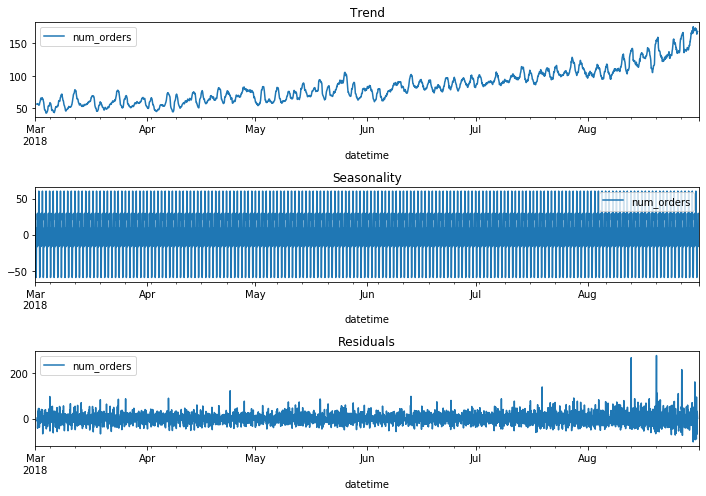

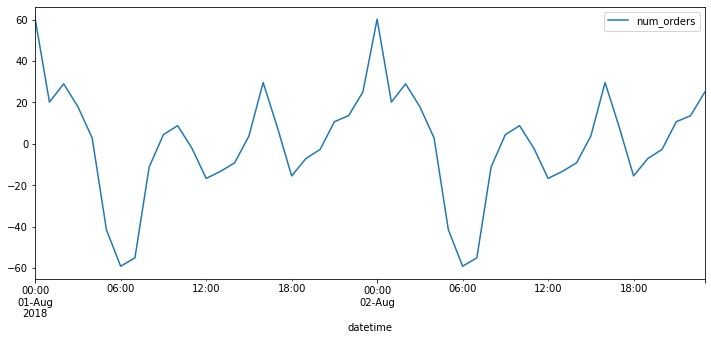

In [137]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(10, 7))
ax = plt.gca()
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()
plt.show()

plt.figure(figsize = (12, 5))
ax = plt.gca()
decomposed = decomposed.seasonal['2018-08-01':'2018-08-02']
decomposed.plot(ax=plt.gca())
plt.show()

## Вывод
Как можно видеть по первой таблице тренд такси - непрерывный плавный рост заказов и как следствие рост количества необходимых авто. По общей таблице сезонность не увидеть, поэтому уменьшим для графика выборку до одного дня. Здесь мы видим явную закономерность: самый большой спрос на такси в 0:00, что циклично даже в рамках одних суток. Самый низкий спрос на авто наблюдается в период с 5:00 до 7:00, c минимумом примерно в 6:00.

# 3. Обучение

In [138]:
# проверка на адекватность моделей 
train1, test1 = train_test_split(data, shuffle=False, test_size=0.1)
print("Средний объём электропотребления в день:", test1['num_orders'].mean())

pred_previous = test1.shift(fill_value = train1['num_orders'].iloc[-1])
adequacy_result = np.sqrt(mean_squared_error(test1['num_orders'], pred_previous))
print("RMSE:", np.sqrt(mean_squared_error(test1['num_orders'], pred_previous)))

Средний объём электропотребления в день: 139.55656108597285
RMSE: 58.856486242815066


In [139]:
data['stats'] = data.num_orders.shift() - data.num_orders.shift(2)

In [140]:
# создание функции признаков
def make_features(data, max_lag, rolling_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for i in range(1, max_lag + 1):
        data['lag_{}'.format(i)] = data['num_orders'].shift(i)
    
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_size).mean()
    
make_features(data, 200, 20)

# разделение на тренировочную и тестовую выборку
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

# проверка разделения
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

# функция разделения на фитчи и таргет
def feat_targ(name):
    name_features = name.drop('num_orders', axis = 1)
    name_target = name['num_orders']
    return name_features, name_target

features_train, target_train = feat_targ(train)
features_test, target_test = feat_targ(test)

2018-03-09 08:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [145]:
def rmse(pred,targ):
    return np.sqrt(mean_squared_error(pred,targ))

In [146]:
tscv = TimeSeriesSplit(n_splits=3)

In [147]:
# линейная регрессия (везде используем GridSearchCV)
lr_cv = LinearRegression()
regression_parametrs = {'fit_intercept' : [True,False]}

scorer = make_scorer(rmse, greater_is_better = False)
grid_lir = GridSearchCV(lr_cv,regression_parametrs, iid=True, cv = tscv.split(features_train), scoring = scorer)
grid_lir.fit(features_train, target_train)

print('The parameters combination that would give best RMSE is : ')
print(grid_lir.best_params_)
print('The RMSE accuracy achieved after parameter tuning via grid search is : ', grid_lir.best_score_)

The parameters combination that would give best RMSE is : 
{'fit_intercept': True}
The RMSE accuracy achieved after parameter tuning via grid search is :  -23.74153988513997


In [ ]:
%%time
# случайный лес 
rfr = RandomForestRegressor()
forest_parametrs = { 'n_estimators': range (10, 31, 10),
              'max_depth': range (1,5, 2),
              'min_samples_leaf': range (1,3),
              'min_samples_split': range (2,10,2)}

scorer = make_scorer(rmse, greater_is_better = False)
grid_rfr = GridSearchCV(rfr, forest_parametrs, iid=True, cv = tscv.split(features_train), scoring = scorer)
grid_rfr.fit(features_train, target_train)

print('The parameters combination that would give best RMSE is : ')
print(grid_rfr.best_params_)
print('The RMSE accuracy achieved after parameter tuning via grid search is : ', grid_rfr.best_score_)

# 4. Тестирование

In [133]:
# предскажем на тестовой выборке для линейной регрессиии 
l_model = LinearRegression(**grid_lir.best_params_)
l_model.fit(features_train, target_train)
l_predicted_test = l_model.predict(features_test)

# посчитаем RMSE для линейной регрессиии
result_1 = np.sqrt(mean_squared_error(target_test,l_predicted_test))
print('Корень среднеквадратичной ошибки для модели линейной регрессииина тестовой  выборке:', result_1)


# предскажем на тестовой выборке для случайного леса
r_model = RandomForestRegressor(**grid_rfr.best_params_)
r_model.fit(features_train, target_train)
r_predicted_test = r_model.predict(features_test)

# посчитаем RMSE для случайного леса
result_2 = np.sqrt(mean_squared_error(target_test,r_predicted_test))
print('Корень среднеквадратичной ошибки для модели случайного леса на тестовой  выборке:', result_2)


# сравним с нашими моделями тест на адекватность  
print('Cимметричное среднее абсолютное процентное отклонение для теста на адекватность:', adequacy_result)

Корень среднеквадратичной ошибки для модели линейной регрессииина тестовой  выборке: 35.56064854671828
Корень среднеквадратичной ошибки для модели случайного леса на тестовой  выборке: 47.50942055239067
Cимметричное среднее абсолютное процентное отклонение для теста на адекватность: 58.856486242815066


## Вывод
Как видим получилось удачно обучить линейную регрессию, она показала хороший результат на тестовых данных (RMSE = 35.5), подходит нам для решения этой задачи. Можно заметить что решающий лес значительно хуже справился с этой задачей: настолько, что близок по результату к тесту на адеватность.